# TDA for feature extraction

In this notebook, we will illustrate how to extract topological features from lesions in the lungs. 

We start by importing the necessary packages

In [1]:
import TDAfeatures as tf # functions for extracting topological features from 3D images
import random # setting seeds
import os # os independent path construction 
import time # track computation time
import numpy as np # handling arrays and general math
import matplotlib.pyplot as plt # plotting
from PIL import Image # exporting images
import cc3d # connected components 3d array
from persim import plot_diagrams # plotting persistence diagrams
import pandas as pd # working with data frames
import nibabel as nib # working with neuroimaging data
import nrrd # working with nearly raw raster data
import plotly # 3d plotting
import plotly.graph_objs as go # 3d plotting configuration
from skimage.measure import marching_cubes # lesion mask to surface mesh
from mpl_toolkits.mplot3d.art3d import Poly3DCollection # plotting meshes
from ripser import ripser # approximate persistent homology computation
import scipy # t-test
import gudhi # compute bottleneck distances
from gudhi.representations.preprocessing import DiagramScaler, DiagramSelector, Padding, BirthPersistenceTransform
from sklearn.model_selection import train_test_split # split training and test data
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.svm import LinearSVC # support vector machine model
from sklearn.linear_model import LogisticRegression, Ridge # linear regression based models
from sklearn.ensemble import RandomForestClassifier # random forest classification model
from sklearn.pipeline import Pipeline # machine learning pipelines
from sklearn.model_selection import GridSearchCV # hyperparameter optimization
from sklearn import preprocessing # data scaling
from sklearn.metrics import plot_roc_curve # plot ROC curve
from sklearn.pipeline import make_pipeline # make pipeline for machine learning
from mlxtend.classifier import StackingCVClassifier # stacking classifier with cross-validation
from mlxtend.feature_selection import ColumnSelector # select columns for ensemble method
from sklearn.feature_selection import SelectKBest, chi2 # feature selection
from sklearn.manifold import MDS # MDS plot
from sklearn.metrics import mean_squared_error, roc_curve, auc # various evaluation metrics

In [14]:
#pd.read_csv(os.path.join("Code", "Features.csv")).shape
#pd.read_csv(os.path.join("Code", "Image.csv")).shape
pd.read_csv("features_with_pdl1outcomes_20200426.csv")

Unnamed: 0  PatientID  GENDER(0:Male;1:Female) CANONICAL_RACE  TPS  \
0             2  OG16ec264                    False          White    5   
1             3  OG16ec779                    False          Asian   50   
2             6  OG16ec3fb                    False          Asian    0   
3             7  OG16ec3fb                    False          Asian    0   
4             9  OG16ec768                     True          White    0   
..          ...        ...                      ...            ...  ...   
140         185  OG16ec202                     True          White    0   
141         186  OG16ec20c                     True          White    0   
142         187  OG16ec269                     True          Black  100   
143         188  OG16ec014                     True          Other    0   
144         190  OG16ec3ed                    False          White   80   

                                        dicom_location  \
0    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
1    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
2    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
3    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
4    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
..                                                 ...   
140  /share/pi/ogevaert/STANFORDLungProject/Upload_...   
141  /share/pi/ogevaert/STANFORDLungProject/Upload_...   
142  /share/pi/ogevaert/STANFORDLungProject/Upload_...   
143  /share/pi/ogevaert/STANFORDLungProject/Upload_...   
144  /share/pi/ogevaert/STANFORDLungProject/Upload_...   

                                                 Image  \
0    /share/pi/ogevaert/STANFORDLungProject/niftis/...   
1    /share/pi/ogevaert/STANFORDLungProject/niftis/...   
2    /share/pi/ogevaert/STANFORDLungProject/niftis/...   
3    /share/pi/ogevaert/STANFORDLungProject/niftis/...   
4    /share/pi/ogevaert/STANFORDLungProject/niftis/...   
..                                                 ...   
140  /share/pi/ogevaert/STANFORDLungProject/niftis/...   
141  /share/pi/ogevaert/STANFORDLungProject/niftis/...   
142  /share/pi/ogevaert/STANFORDLungProject/niftis/...   
143  /share/pi/ogevaert/STANFORDLungProject/niftis/...   
144  /share/pi/ogevaert/STANFORDLungProject/niftis/...   

                                                  Mask  \
0    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
1    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
2    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
3    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
4    /share/pi/ogevaert/STANFORDLungProject/Upload_...   
..                                                 ...   
140  /share/pi/ogevaert/STANFORDLungProject/Upload_...   
141  /share/pi/ogevaert/STANFORDLungProject/Upload_...   
142  /share/pi/ogevaert/STANFORDLungProject/Upload_...   
143  /share/pi/ogevaert/STANFORDLungProject/Upload_...   
144  /share/pi/ogevaert/STANFORDLungProject/Upload_...   

                                     SeriesInstanceUID  \
0    1.2.840.4267.32.926600235643239910745878239133...   
1    1.2.840.4267.32.927145430654524331318002234320...   
2    1.2.840.4267.32.150512019281401568541077071804...   
3    1.2.840.4267.32.150512019281401568541077071804...   
4    1.2.840.4267.32.860872111530019376592828806800...   
..                                                 ...   
140  1.2.840.4267.32.987130287860743850344127904557...   
141  1.2.840.4267.32.270482483849633918012481436606...   
142  1.2.840.4267.32.201109917346165196935698054868...   
143  1.2.840.4267.32.286336665267318281271832013043...   
144  1.2.840.4267.32.143124797190788005646435386542...   

    diagnostics_Versions_PyRadiomics  ...  \
0                v3.0.post2+g896682d  ...   
1                v3.0.post2+g896682d  ...   
2                v3.0.post2+g896682d  ...   
3                v3.0.post2+g896682d  ...   
4                v3.0.post2+g896682d  ...   
..                               ...  ...   
1

## Computing the Persistence Diagrams from Images

We illustrate our procedure through an example lesion.

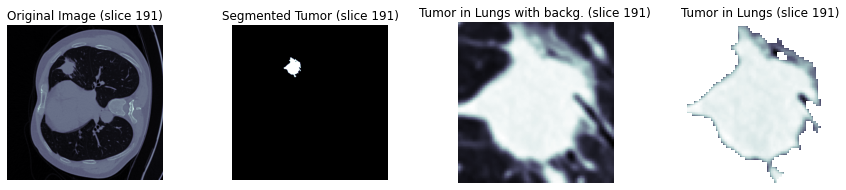

In [15]:
patient_idx = 11
patient = "patient" + str(patient_idx).zfill(3)
img_path_local = os.path.join("image", patient + ".nii.gz")
mask_path_local = os.path.join("mask", patient + ".nrrd")

# extract the radiology image
lungs_img = np.array(nib.load(img_path_local).dataobj) 

# extract the segmented tumor
lesion_mask = nrrd.read(mask_path_local)[0]

# extract the tumor pixels from the radiology images
lesion_img_box = tf.segment_3Darray(lesion_mask, lungs_img, fillnan=False)
lesion_img = tf.segment_3Darray(lesion_mask, lungs_img)

current_tumor_pixels = -1
for idx in range(lesion_mask.shape[2]):
    tumor_pixels_at_idx = np.sum(lesion_mask[:,:,idx] == 1)
    if tumor_pixels_at_idx > current_tumor_pixels:
        current_tumor_pixels = tumor_pixels_at_idx
        tumor_idx = idx

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = axes.flatten()

ax[0].imshow(lungs_img[:,:,tumor_idx], cmap=plt.cm.bone)
ax[0].set_axis_off()
ax[0].set_title("Original Image (slice " + str(tumor_idx) + ")", fontsize=12)

ax[1].imshow(lesion_mask[:,:,tumor_idx], cmap=plt.cm.bone)
ax[1].set_axis_off()
ax[1].set_title("Segmented Tumor (slice " + str(tumor_idx) + ")", fontsize=12)

ax[2].imshow(lesion_img_box[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[2].set_axis_off()
ax[2].set_title("Tumor in Lungs with backg. (slice " + str(tumor_idx) + ")", fontsize=12)

ax[3].imshow(lesion_img[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[3].set_axis_off()
ax[3].set_title("Tumor in Lungs (slice " + str(tumor_idx) + ")", fontsize=12)

fig.tight_layout()
plt.show()

In [16]:
nifti_file = nib.load(img_path_local)

In [21]:
import SimpleITK as sitk # handling dicom images

reader = sitk.ImageFileReader()
reader.SetFileName(img_path_local)
vol = reader.Execute()

In [22]:
vol.TransformContinuousIndexToPhysicalPoint([1, 1, 1])

(-136.5537109375, -319.0537109375, -266.1000061035156)

Time for computing persistence: 00:00:11


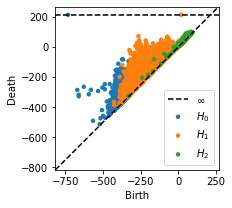

In [21]:
start_time = time.time()
dgms_img = tf.lower_star_img3D(lesion_img)
elapsed_time = time.time() - start_time
print("Time for computing persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

plt.figure(figsize=(3, 3))
plot_diagrams(dgms_img)
plt.show()

We can also take into account the pixels in the bounding box of the image when computing persistent homology. 

Time for computing persistence: 00:00:11


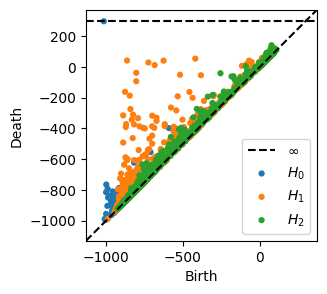

In [22]:
start_time = time.time()
dgms_box = tf.lower_star_img3D(lesion_img_box)
elapsed_time = time.time() - start_time
print("Time for computing persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

plt.figure(figsize=(3, 3))
plot_diagrams(dgms_box)
plt.show()

The diagrams for each lesion are computed on the Stanford Nero Computing server, as a few of them cannot be computed locally due to insufficient memory.

## Computing the Persistence Diagrams from Point Clouds

We illustrate our procedure through an example lesion.

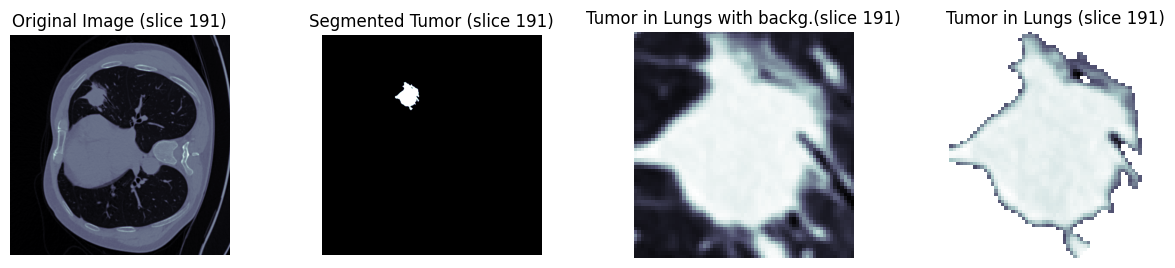

In [23]:
patient_idx = 11
patient = "patient" + str(patient_idx).zfill(3)
img_path_local = os.path.join("image", patient + ".nii.gz")
mask_path_local = os.path.join("mask", patient + ".nrrd")

# extract the radiology image
lungs_img = np.array(nib.load(img_path_local).dataobj)

# extract the segmented tumor
lesion_mask = nrrd.read(mask_path_local)[0]

# extract the tumor pixels from the radiology images
lesion_img_box = tf.segment_3Darray(lesion_mask, lungs_img, fillnan=False)
lesion_img = tf.segment_3Darray(lesion_mask, lungs_img)

current_tumor_pixels = -1
for idx in range(lesion_mask.shape[2]):
    tumor_pixels_at_idx = np.sum(lesion_mask[:,:,idx] == 1)
    if tumor_pixels_at_idx > current_tumor_pixels:
        current_tumor_pixels = tumor_pixels_at_idx
        tumor_idx = idx

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = axes.flatten()

ax[0].imshow(lungs_img[:,:,tumor_idx], cmap=plt.cm.bone)
ax[0].set_axis_off()
ax[0].set_title("Original Image (slice " + str(tumor_idx) + ")", fontsize=12)

ax[1].imshow(lesion_mask[:,:,tumor_idx], cmap=plt.cm.bone)
ax[1].set_axis_off()
ax[1].set_title("Segmented Tumor (slice " + str(tumor_idx) + ")", fontsize=12)

ax[2].imshow(lesion_img_box[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[2].set_axis_off()
ax[2].set_title("Tumor in Lungs with backg.(slice " + str(tumor_idx) + ")", fontsize=12)

ax[3].imshow(lesion_img[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[3].set_axis_off()
ax[3].set_title("Tumor in Lungs (slice " + str(tumor_idx) + ")", fontsize=12)

fig.tight_layout()
plt.show()

We define a point cloud from the boundary pixels of the lesion.

In [24]:
verts, faces, normals, values = marching_cubes(lesion_mask)
print("Number of points on surface: " + str(verts.shape[0]))

# configure Plotly to be rendered inline in the notebook
plotly.offline.init_notebook_mode()

# configure the trace
trace = go.Scatter3d(
    x = verts[:,0],
    y = verts[:,1],
    z = verts[:,2],
    mode = "markers",
    marker={
        "size": .5,
        "opacity": 0.8,
    }
)

# configure the layout
layout = go.Layout(
    margin={"l": 0, "r": 0, "b": 0, "t": 0},
    width = 300,
    height = 300
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

Number of points on surface: 15513


The point clouds generally too large for computing 2-dimensional persistent homology. We can overcome this issue by using a theoretically justified approximation algorithm for computing our diagrams. The simplicial complex is constructed on a set of landmarks in stead. However, this itroduces some randomness and an additional hyperparameter.

Time for computing persistence: 00:00:25


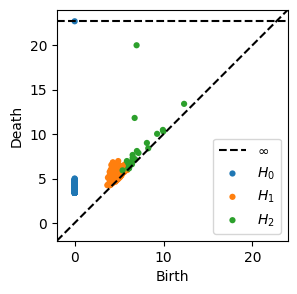

In [28]:
n_landmarks = 500

start_time = time.time()
dgms = ripser(verts, maxdim=2, n_perm=n_landmarks)["dgms"]
elapsed_time = time.time() - start_time
print("Time for computing persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

plt.figure(figsize=(3, 3))
plot_diagrams(dgms)
plt.show()

The persistence diagram for each tumor are approximated on the Stanford Nero Computing Server.

## Topological Features from Meshes

A first possible approach for meshes is through the exact same procedure for for point clouds. Instead, we use the metric defined by the mesh in stead of the euclidean distances between the points for defining the filtration. We illustrate our procedure through an example lesion.

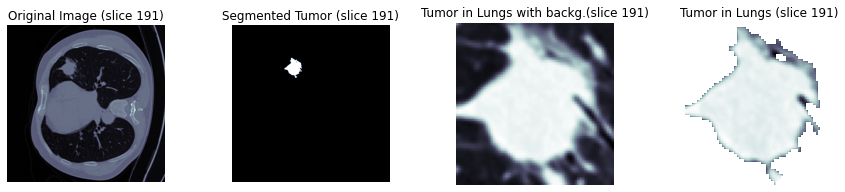

In [18]:
patient_idx = 4
patient_idx = 11
patient = "patient" + str(patient_idx).zfill(3)
img_path_local = os.path.join("image", patient + ".nii.gz")
mask_path_local = os.path.join("mask", patient + ".nrrd")

# extract the radiology image
lungs_img = np.array(nib.load(img_path_local).dataobj)

# extract the segmented tumor
lesion_mask = nrrd.read(mask_path_local)[0]

# extract the tumor pixels from the radiology images
lesion_img_box = tf.segment_3Darray(lesion_mask, lungs_img, fillnan=False)
lesion_img = tf.segment_3Darray(lesion_mask, lungs_img)

current_tumor_pixels = -1
for idx in range(lesion_mask.shape[2]):
    tumor_pixels_at_idx = np.sum(lesion_mask[:,:,idx] == 1)
    if tumor_pixels_at_idx > current_tumor_pixels:
        current_tumor_pixels = tumor_pixels_at_idx
        tumor_idx = idx

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = axes.flatten()

ax[0].imshow(lungs_img[:,:,tumor_idx], cmap=plt.cm.bone)
ax[0].set_axis_off()
ax[0].set_title("Original Image (slice " + str(tumor_idx) + ")", fontsize=12)

ax[1].imshow(lesion_mask[:,:,tumor_idx], cmap=plt.cm.bone)
ax[1].set_axis_off()
ax[1].set_title("Segmented Tumor (slice " + str(tumor_idx) + ")", fontsize=12)

ax[2].imshow(lesion_img_box[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[2].set_axis_off()
ax[2].set_title("Tumor in Lungs with backg.(slice " + str(tumor_idx) + ")", fontsize=12)

ax[3].imshow(lesion_img[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[3].set_axis_off()
ax[3].set_title("Tumor in Lungs (slice " + str(tumor_idx) + ")", fontsize=12)

fig.tight_layout()
plt.show()

Number of vertices on surface: 15513


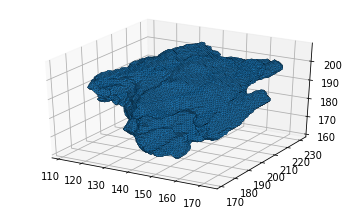

In [19]:
from mpl_toolkits.mplot3d import Axes3D

verts, faces, normals, values = marching_cubes(lesion_mask)
print("Number of vertices on surface: " + str(verts.shape[0]))

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces], linewidths=.1)
mesh.set_edgecolor("k")
ax.add_collection3d(mesh)
plt.tight_layout()
plt.show()

We can compute the geodesic distances defined by the mesh faces as follows.

In [17]:
start_time = time.time()
geoD = tf.geodesic_distances(faces)
elapsed_time = time.time() - start_time
print("Time for computing geodesic distances: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

TypeError: geodesic_distances() missing 1 required positional argument: 'faces'

We can approximate persistent homology computation for arbitrary distance matrices as follows. 

Time for computing persistence: 00:00:47


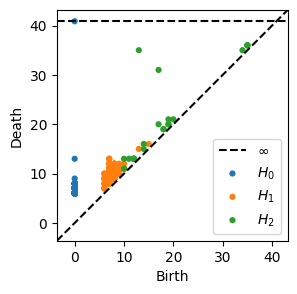

In [22]:
n_landmarks = 500

start_time = time.time()
dgms = ripser(geoD, maxdim=2, distance_matrix=True, n_perm=n_landmarks)["dgms"]
elapsed_time = time.time() - start_time
print("Time for computing persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

plt.figure(figsize=(3, 3))
plot_diagrams(dgms)
plt.show()

In general, it is very costly---both in terms of time and memory---to compute these diagrams for all meshes. Hence, we use a different approach that was specifally designed for learning from these meshes through the smooth Euler characteristic transform. These characteristics are compute in R, for which we first need to create a folder that contains the slices of each tumor mask and for each patient as image files.

In [20]:
mask_path = "mask"
SECT_mask_path = os.path.join("SECT", "mask")
n_patients = len(os.listdir(mask_path))

for idx in range(n_patients):
    
    print("progress: " + str(round(100 * idx / n_patients, 2)).ljust(5, "0") + "%", end="\r")
    mask_file = os.path.join(mask_path, "patient" + str(idx).zfill(3) + ".nrrd")
    SECT_folder = os.path.join(SECT_mask_path, "patient" + str(idx).zfill(3))

    if not os.path.exists(SECT_folder):
        os.mkdir(SECT_folder)
        
        # save the slices of the lagest component of the tumor to images
        lesion_mask = nrrd.read(mask_file)[0]
        zmin, zmax = tf.bbox_3D(lesion_mask)[4:6]
        lesion_mask = lesion_mask[:,:,zmin:zmax]
        components = cc3d.connected_components(lesion_mask, connectivity=6)
        component_label, component_size = np.unique(components, return_counts=True)
        largest_component_label = component_label[np.argmax(component_size[1:]) + 1]
        lesion_mask[components != largest_component_label] = 0
        
        for idx in range(lesion_mask.shape[2]):
            im = Image.fromarray(255 * lesion_mask[:,:,idx].astype(np.uint8))
            im.save(os.path.join(SECT_folder, "slice" + str(idx) + ".png"), "PNG")
        
print("progress: 100.0%", end="\r")

## Computing the Location/Orientation Features.

We finally show how to compute location/orientaton features for an example lesion.

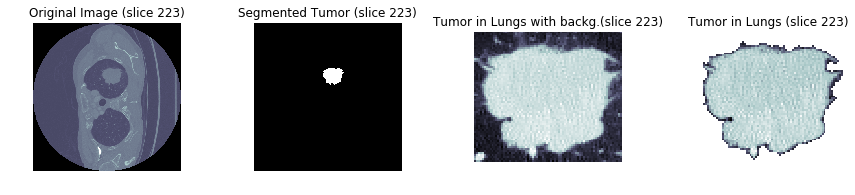

In [2]:
patient_idx = 8
patient = "patient" + str(patient_idx).zfill(3)
img_path_local = os.path.join("image", patient + ".nii.gz")
mask_path_local = os.path.join("mask", patient + ".nrrd")

# extract the radiology image
lungs_img = np.array(nib.load(img_path_local).dataobj)

# extract the segmented tumor
lesion_mask = nrrd.read(mask_path_local)[0]

# extract the tumor pixels from the radiology images
lesion_img_box = tf.segment_3Darray(lesion_mask, lungs_img, fillnan=False)
lesion_img = tf.segment_3Darray(lesion_mask, lungs_img)

current_tumor_pixels = -1
for idx in range(lesion_mask.shape[2]):
    tumor_pixels_at_idx = np.sum(lesion_mask[:,:,idx] == 1)
    if tumor_pixels_at_idx > current_tumor_pixels:
        current_tumor_pixels = tumor_pixels_at_idx
        tumor_idx = idx

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = axes.flatten()

ax[0].imshow(lungs_img[:,:,tumor_idx], cmap=plt.cm.bone)
ax[0].set_axis_off()
ax[0].set_title("Original Image (slice " + str(tumor_idx) + ")", fontsize=12)

ax[1].imshow(lesion_mask[:,:,tumor_idx], cmap=plt.cm.bone)
ax[1].set_axis_off()
ax[1].set_title("Segmented Tumor (slice " + str(tumor_idx) + ")", fontsize=12)

ax[2].imshow(lesion_img_box[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[2].set_axis_off()
ax[2].set_title("Tumor in Lungs with backg.(slice " + str(tumor_idx) + ")", fontsize=12)

ax[3].imshow(lesion_img[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[3].set_axis_off()
ax[3].set_title("Tumor in Lungs (slice " + str(tumor_idx) + ")", fontsize=12)

fig.tight_layout()
plt.show()

The features are easily computed using the following function.

In [10]:
tf.location_orientation_features(lesion_mask)

{'size': 77694,
 'xmin': 149,
 'xmax': 216,
 'ymin': 235,
 'ymax': 311,
 'zmin': 192,
 'zmax': 243,
 'xcenter': 182.5,
 'ycenter': 273.0,
 'zcenter': 217.5,
 'pca1_1': -0.14723588141338906,
 'pca1_2': -0.9874815788720119,
 'pca1_3': 0.056583801682645346,
 'pca2_1': 0.9866246711420934,
 'pca2_2': -0.14258079038207636,
 'pca2_3': 0.07900934443329044,
 'pca3_1': 0.06995250901989403,
 'pca3_2': -0.06745998519463894,
 'pca3_3': -0.9952666963579967,
 'lambda1': 231.606883882593,
 'lambda2': 184.07252601147883,
 'lambda3': 82.31619451472716}

We compute the location/orientation features of all tumors.

In [14]:
n_patients = len(os.listdir("image"))
location_orientation_features = list()

### Compute persistence diagrams for each lesion ###

for idx in range(n_patients):
    
    print("progress: " + str(round(100 * idx / n_patients, 2)).ljust(5, "0") + "%", end="\r")
    patient = "patient" + str(idx).zfill(3)

    # extract the segmented tumor
    lesion_mask = nrrd.read(os.path.join("mask", patient + ".nrrd"))[0] 

    # compute location/orientation features
    location_orientation_features.append(tf.location_orientation_features(lesion_mask))

print("progress: 100.0%", end="\r")

# save the location/orientation features
pd.DataFrame(location_orientation_features).to_csv("location_orientation_features.csv")

## Univariate Analyisis of Topological Features

We compare the distribution of our topological features for different classes. We start by viewing the distribution of outcome variable.

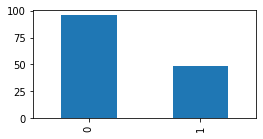

In [87]:
y = np.array(pd.read_csv(os.path.join("code", "features_with_pdl1outcomes_20200426.csv"), 
                         index_col=0)["binarized_outcome"]).astype("int")
TPS = np.array(pd.read_csv(os.path.join("code", "features_with_pdl1outcomes_20200426.csv"), 
                         index_col=0)["binarized_outcome"]).astype("int")
pd.DataFrame(y).iloc[:,0].value_counts().plot(kind="bar", figsize=(4, 2))

We start by extracting the features.

In [88]:
add_features_img = True
add_features_img_box = True
add_features_point_cloud = False

X_top = pd.DataFrame()

if add_features_img:
    ### Topological features for segmented images ###
    diagram_path_img_dim0 = os.path.join("diagram", "image", "dgm0")
    diagram_path_img_dim1 = os.path.join("diagram", "image", "dgm1")
    diagram_path_img_dim2 = os.path.join("diagram", "image", "dgm2")
    features_img_dim0, features_img_dim1, features_img_dim2 = list(), list(), list()

    for idx in range(len(os.listdir(diagram_path_img_dim0))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_img_dim0, patient + ".npy"))
        features_img_dim0.append(tf.persistence_statistics(dgm))

    for idx in range(len(os.listdir(diagram_path_img_dim1))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_img_dim1, patient + ".npy"))
        features_img_dim1.append(tf.persistence_statistics(dgm))

    for idx in range(len(os.listdir(diagram_path_img_dim2))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_img_dim2, patient + ".npy"))
        features_img_dim2.append(tf.persistence_statistics(dgm))
        
    features_img_dim0 = pd.DataFrame(features_img_dim0)
    features_img_dim1 = pd.DataFrame(features_img_dim1)
    features_img_dim2 = pd.DataFrame(features_img_dim2)
        
    X_top = pd.concat([X_top,
                       features_img_dim0.rename(
                           columns={column:"img_dim0_" + column for column in features_img_dim0.columns}),
                       features_img_dim1.rename(
                           columns={column:"img_dim1_" + column for column in features_img_dim1.columns}),
                       features_img_dim2.rename(
                           columns={column:"img_dim2_" + column for column in features_img_dim2.columns})], 
                      axis=1)
    
    del features_img_dim0, features_img_dim1, features_img_dim2
    

if add_features_img_box:
    ### Topological features for segmented images with boundary box background ###
    diagram_path_img_box_dim0 = os.path.join("diagram", "image_box", "dgm0")
    diagram_path_img_box_dim1 = os.path.join("diagram", "image_box", "dgm1")
    diagram_path_img_box_dim2 = os.path.join("diagram", "image_box", "dgm2")
    features_img_box_dim0, features_img_box_dim1, features_img_box_dim2 = list(), list(), list()

    for idx in range(len(os.listdir(diagram_path_img_box_dim0))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_img_box_dim0, patient + ".npy"))
        features_img_box_dim0.append(tf.persistence_statistics(dgm))

    for idx in range(len(os.listdir(diagram_path_img_box_dim1))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_img_box_dim1, patient + ".npy"))
        features_img_box_dim1.append(tf.persistence_statistics(dgm))

    for idx in range(len(os.listdir(diagram_path_img_box_dim2))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_img_box_dim2, patient + ".npy"))
        features_img_box_dim2.append(tf.persistence_statistics(dgm))

    features_img_box_dim0 = pd.DataFrame(features_img_box_dim0).drop(["no_infinite_lifespans"], axis=1)
    features_img_box_dim1 = pd.DataFrame(features_img_box_dim1).drop(["no_infinite_lifespans"], axis=1)
    features_img_box_dim2 = pd.DataFrame(features_img_box_dim2).drop(["no_infinite_lifespans"], axis=1)
    
    X_top = pd.concat([X_top,
                       features_img_box_dim0.rename(
                           columns={column:"img_box_dim0_" + column for column in features_img_box_dim0.columns}),
                       features_img_box_dim1.rename(
                           columns={column:"img_box_dim1_" + column for column in features_img_box_dim1.columns}),
                       features_img_box_dim2.rename(
                           columns={column:"img_box_dim2_" + column for column in features_img_box_dim2.columns})],
                      axis=1)
    
    del features_img_box_dim0, features_img_box_dim1, features_img_box_dim2


if add_features_point_cloud:
    ### Topological features for point clouds of tumor surface pixels ###
    diagram_path_point_cloud_dim0 = os.path.join("diagram", "point_cloud", "dgm0")
    diagram_path_point_cloud_dim1 = os.path.join("diagram", "point_cloud", "dgm1")
    diagram_path_point_cloud_dim2 = os.path.join("diagram", "point_cloud", "dgm2")
    features_point_cloud_dim0, features_point_cloud_dim1, features_point_cloud_dim2 = list(), list(), list()

    for idx in range(len(os.listdir(diagram_path_point_cloud_dim0))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_point_cloud_dim0, patient + ".npy"))
        features_point_cloud_dim0.append(tf.persistence_statistics(dgm))

    for idx in range(len(os.listdir(diagram_path_point_cloud_dim1))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_point_cloud_dim1, patient + ".npy"))
        features_point_cloud_dim1.append(tf.persistence_statistics(dgm))

    for idx in range(len(os.listdir(diagram_path_point_cloud_dim2))):

        patient = "patient" + str(idx).zfill(3)
        dgm = np.load(os.path.join(diagram_path_point_cloud_dim2, patient + ".npy"))
        features_point_cloud_dim2.append(tf.persistence_statistics(dgm))
    
    features_point_cloud_dim0 = pd.DataFrame(features_point_cloud_dim0).drop(["min_birth"], axis=1)
    features_point_cloud_dim0 = pd.DataFrame(features_point_cloud_dim0).drop(["no_infinite_lifespans"], axis=1)
    features_point_cloud_dim1 = pd.DataFrame(features_point_cloud_dim1).drop(["no_infinite_lifespans"], axis=1)
    features_point_cloud_dim2 = pd.DataFrame(features_point_cloud_dim2).drop(["no_infinite_lifespans"], axis=1)

    X_top = pd.concat([X_top,
                       features_point_cloud_dim0.rename(
                           columns={column:"point_cloud_dim0_" + column for column in features_point_cloud_dim0.columns}),
                       features_point_cloud_dim1.rename(
                           columns={column:"point_cloud_dim1_" + column for column in features_point_cloud_dim1.columns}),
                       features_point_cloud_dim2.rename(
                           columns={column:"point_cloud_dim2_" + column for column in features_point_cloud_dim2.columns})],
                      axis=1)
    
    del features_point_cloud_dim0, features_point_cloud_dim1, features_point_cloud_dim2

We investigate whether any of the  topological features significantly differ for the two classes.

In [89]:
alpha = 0.05
topological_significant = list()
topological_ttests = scipy.stats.ttest_ind(X_top.iloc[np.where(y == 0)[0],:],
                                           X_top.iloc[np.where(y == 1)[0],:],
                                           equal_var=False)[1]
argsort_ttests = np.argsort(topological_ttests)

for idx in argsort_ttests:
    if topological_ttests[idx] <= alpha:
        topological_significant.append(X_top.columns[idx])
        
print(str(len(topological_significant)) + " out of " + str(len(X_top.columns)) + 
      " (~" + str(round(100 * len(topological_significant) / len(X_top.columns), 3)) + 
      "%) features found to be significant for alpha = 0.05\n")

print("\033[1mp-values t-tests\033[0m\n")
for idx in argsort_ttests:
    if topological_ttests[idx] <= alpha:
        print ("\033[1m" + X_top.columns[idx] + ": " + str(topological_ttests[idx]) + " \033[0m")
    else:
        print (X_top.columns[idx] + ": " + str(topological_ttests[idx]))

8 out of 117 (~6.838%) features found to be significant for alpha = 0.05

p-values t-tests

img_dim0_skew_finite_midlifes: 0.0008972850466800111 
img_box_dim0_std_finite_lifespans: 0.02045610383298918 
img_box_dim1_Q3_finite_midlifes: 0.026827642725915042 
img_dim0_skew_finite_lifespans: 0.03215204017317972 
img_box_dim2_mean_finite_midlifes: 0.03393532482002882 
img_dim1_median_finite_midlifes: 0.0467470663758371 
img_dim0_kurtosis_finite_lifespans: 0.04789850796270592 
img_dim0_no_finite_lifespans: 0.04902403950610825 
img_dim1_no_finite_lifespans: 0.053419823859183056
img_dim0_min_birth: 0.06383304088907925
img_box_dim2_Q1_finite_midlifes: 0.06485236173609946
img_dim0_Q1_finite_midlifes: 0.06586706102661467
img_dim0_Q3_finite_midlifes: 0.06729565142996877
img_dim1_entropy_finite_lifespans: 0.06736017649001605
img_dim1_Q1_finite_midlifes: 0.067766631388527
img_box_dim2_median_finite_midlifes: 0.07034312432626161
img_dim2_entropy_finite_lifespans: 0.07175104151624151
img_dim0_mean_fin

## Supervised Learning with Concatenated Features (Classification)

We investigate different models based on combinations of topological, radiomics, and location/orientation features.

In [90]:
icc_threshold_radiomics = 0.8
        
radiomics_features = pd.read_csv(os.path.join("code", "icc_values.csv"), index_col=0)
radiomics_features = list(radiomics_features["feature"][radiomics_features["icc_value"] > 
                                                            icc_threshold_radiomics])
X_rad = pd.read_csv(os.path.join("code", "features_with_pdl1outcomes_20200426.csv"), 
                    index_col=0)[radiomics_features]
X_rad.index = range(X_rad.shape[0])
    
X_locor = pd.read_csv("location_orientation_features.csv", index_col=0)

We split the data in training and test data.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(pd.concat([X_top, X_rad, X_locor], axis=1), 
                                                    y, test_size=0.3, random_state=42, stratify=y)

We now build a classification model.

In [104]:
topological_features = True
radiomics_features = True
location_orientation_features = True

columns = list()

if topological_features:
    columns += list(X_top.columns)

if radiomics_features:
    columns += list(X_rad.columns)
    
if location_orientation_features:
    columns += list(X_locor.columns)
    
print("Number of features: " + str(len(columns)))

# Define a pipeline to search for the best combination of hyperparameters

#preprocess = preprocessing.StandardScaler()
preprocess = preprocessing.MinMaxScaler()
selector = SelectKBest(chi2)
pca = PCA()
#svm = LinearSVC()
svm = LinearSVC(penalty="l1", dual=False)
RC = RandomForestClassifier(random_state=42)
logistic = LogisticRegression()

pipe = Pipeline(steps=[("colsel", ColumnSelector(cols=columns)),
                       ("preprocess", preprocess), 
                       #("selector", selector),
                       ("pca", pca), 
                       #("logistic", logistic)])
                       ("svm", svm)])
                       #("RC", RC)])

param_grid = {
    #"selector__k": np.arange(2, np.min([X_train.shape[1] + 1, 25]), 3),
    "pca__n_components": np.arange(2, np.min([X_train.shape[1] + 1, 25]), 3),
    #"logistic__C": [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 1e1, 1e2]
    "svm__C": [1e-05, 1e-04, 1e-03, 1e-02, 1e-01]
    #"RC__n_estimators": [10, 25, 50, 75, 100, 125, 150]
}

search = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Number of features: 739
Best parameter (CV score=0.600):
{'pca__n_components': 8, 'svm__C': 0.1}


We visualize the ROC for our best model.

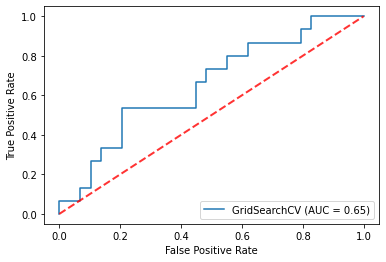

In [105]:
fig, ax = plt.subplots()
plot_roc_curve(search, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=.8)
plt.show()

## Supervised Learning with Concatenated Features (Regression)

We investigate different models based on combinations of topological, radiomics, and location/orientation features.

In [213]:
icc_threshold_radiomics = 0.8
        
radiomics_features = pd.read_csv(os.path.join("code", "icc_values.csv"), index_col=0)
radiomics_features = list(radiomics_features["feature"][radiomics_features["icc_value"] > 
                                                            icc_threshold_radiomics])
X_rad = pd.read_csv(os.path.join("code", "features_with_pdl1outcomes_20200426.csv"), 
                    index_col=0)[radiomics_features]
X_rad.index = range(X_rad.shape[0])
    
X_locor = pd.read_csv("location_orientation_features.csv", index_col=0)

We split the data in training and test data.

In [214]:
X_train, X_test, y_train, y_test = train_test_split(pd.concat([X_top, X_rad, X_locor], axis=1), 
                                                    meta["TPS"], test_size=0.3, random_state=42)

We now build a regression model.

In [219]:
topological_features = True
radiomics_features = True
location_orientation_features = False

columns = list()

if topological_features:
    columns += list(X_top.columns)

if radiomics_features:
    columns += list(X_rad.columns)
    
if location_orientation_features:
    columns += list(X_locor.columns)
    
print("Number of features: " + str(len(columns)))

# Define a pipeline to search for the best combination of hyperparameters

#preprocess = preprocessing.StandardScaler()
preprocess = preprocessing.MinMaxScaler()
selector = SelectKBest(chi2)
pca = PCA()
#svm = LinearSVC()
ridge = Ridge()

pipe = Pipeline(steps=[("colsel", ColumnSelector(cols=columns)),
                       ("preprocess", preprocess), 
                       ("selector", selector),
                       #("pca", pca), 
                       ("ridge", ridge)])

param_grid = {
    "selector__k": np.arange(2, np.min([X_train.shape[1] + 1, 25]), 3),
    #"pca__n_components": np.arange(2, np.min([X_train.shape[1] + 1, 25]), 3),
    "ridge__alpha": [1e-05, 1e-04, 1e-03, 1e-02, 1e-01]
}

search = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_root_mean_squared_error")
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Number of features: 717
Best parameter (CV score=-40.238):
{'ridge__alpha': 0.001, 'selector__k': 2}


We evaluate our best model.

In [220]:
print("RMSE (test):", np.sqrt(mean_squared_error(y_test, search.predict(X_test))))

RMSE (test): 32.78108412842356


## Supervised Learning with Ensemble Model

We build a classification based build by stacking the probability outcome of different models for the different types of features. We first split the data in training and test data.

In [198]:
X_train, X_test, y_train, y_test = train_test_split(pd.concat([X_top, X_rad, X_locor], axis=1), 
                                                    y, test_size=0.3, random_state=42, stratify=y_bin)

We now build a ensemble model for classification.

In [211]:
topological_features = True
radiomics_features = True
location_orientation_features = False

# Define a pipeline to search for the best combination of hyperparameters

classifiers = list()

if topological_features:
    classifiers.append(make_pipeline(ColumnSelector(cols=X_top.columns),
                                     preprocessing.MinMaxScaler(),
                                     SelectKBest(chi2, k=10),
                                     LogisticRegression(C=10)))
    
if radiomics_features:    
    classifiers.append(make_pipeline(ColumnSelector(cols=X_rad.columns),
                                     RandomForestClassifier(random_state=42, n_estimators=75)))
    
if location_orientation_features:
    classifiers.append(make_pipeline(ColumnSelector(cols=X_locor.columns),
                                     preprocessing.StandardScaler(), 
                                     LinearSVC(penalty="l1", dual=False)))

sclf = StackingCVClassifier(classifiers=classifiers, 
                            meta_classifier=LinearSVC(),
                            #meta_classifier=LogisticRegression(),
                            random_state=42)

params = {#"pipeline-1__linearsvc__C": [1e-05, 1e-04, 1e-03, 1e-02, 1e-01],
          #"pipeline-2__randomforestclassifier__n_estimators": [10, 25, 50, 75, 100, 125, 150],
          #"pipeline-3__linearsvc__C": [1e-05, 1e-04, 1e-03, 1e-02, 1e-01],
          "meta_classifier__C": [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1]}

search = GridSearchCV(estimator=sclf, param_grid=params, scoring="roc_auc")
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.615):
{'meta_classifier__C': 0.01}


We visualize the ROC for our best model.

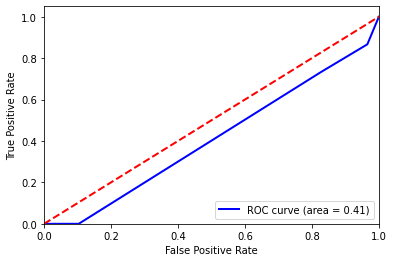

In [212]:
y_score = search.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="blue", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## GUDHI Models to Learn from Persistence Diagrams

We investigate how different models from the GUDHI library are able to learn from these diagrams. We start by extracting the diagrams.

In [60]:
segmented_dgms = {"dim0": list(), "dim1": list(), "dim2": list()}
image_dgms = {"dim0": list(), "dim1": list(), "dim2": list()}
point_cloud_dgms = {"dim0": list(), "dim1": list(), "dim2": list()}

### Diagrams for segmented images ###
diagram_path_img_dim0 = os.path.join("diagram", "image", "dgm0")
diagram_path_img_dim1 = os.path.join("diagram", "image", "dgm1")
diagram_path_img_dim2 = os.path.join("diagram", "image", "dgm2")

for idx in range(len(os.listdir(diagram_path_img_dim0))):

    patient = "patient" + str(idx).zfill(3)
    segmented_dgms["dim0"].append(np.load(os.path.join(diagram_path_img_dim0, patient + ".npy")))

for idx in range(len(os.listdir(diagram_path_img_dim1))):

    patient = "patient" + str(idx).zfill(3)
    segmented_dgms["dim1"].append(np.load(os.path.join(diagram_path_img_dim1, patient + ".npy")))

for idx in range(len(os.listdir(diagram_path_img_dim2))):

    patient = "patient" + str(idx).zfill(3)
    segmented_dgms["dim2"].append(np.load(os.path.join(diagram_path_img_dim2, patient + ".npy")))


### Diagrams for segmented images with boundary box background ###
diagram_path_img_box_dim0 = os.path.join("diagram", "image_box", "dgm0")
diagram_path_img_box_dim1 = os.path.join("diagram", "image_box", "dgm1")
diagram_path_img_box_dim2 = os.path.join("diagram", "image_box", "dgm2")

for idx in range(len(os.listdir(diagram_path_img_box_dim0))):

    patient = "patient" + str(idx).zfill(3)
    image_dgms["dim0"].append(np.load(os.path.join(diagram_path_img_box_dim0, patient + ".npy")))

for idx in range(len(os.listdir(diagram_path_img_box_dim1))):

    patient = "patient" + str(idx).zfill(3)
    image_dgms["dim1"].append(np.load(os.path.join(diagram_path_img_box_dim1, patient + ".npy")))

for idx in range(len(os.listdir(diagram_path_img_box_dim2))):

    patient = "patient" + str(idx).zfill(3)
    image_dgms["dim2"].append(np.load(os.path.join(diagram_path_img_box_dim2, patient + ".npy")))


### Diagrams for point clouds of tumor surface pixels ###
diagram_path_point_cloud_dim0 = os.path.join("diagram", "point_cloud", "dgm0")
diagram_path_point_cloud_dim1 = os.path.join("diagram", "point_cloud", "dgm1")
diagram_path_point_cloud_dim2 = os.path.join("diagram", "point_cloud", "dgm2")

for idx in range(len(os.listdir(diagram_path_point_cloud_dim0))):

    patient = "patient" + str(idx).zfill(3)
    point_cloud_dgms["dim0"].append(np.load(os.path.join(diagram_path_point_cloud_dim0, patient + ".npy")))

for idx in range(len(os.listdir(diagram_path_point_cloud_dim1))):

    patient = "patient" + str(idx).zfill(3)
    point_cloud_dgms["dim1"].append(np.load(os.path.join(diagram_path_point_cloud_dim1, patient + ".npy")))

for idx in range(len(os.listdir(diagram_path_point_cloud_dim2))):

    patient = "patient" + str(idx).zfill(3)
    point_cloud_dgms["dim2"].append(np.load(os.path.join(diagram_path_point_cloud_dim2, patient + ".npy")))

We split the diagrams in training and test diagrams, and learn representations from the training diagrams.

In [ ]:
add_features_img = True
add_features_img_box = True
add_features_point_cloud = True

idx_train, idx_test, y_train, y_test = train_test_split(range(len(y)), y, test_size=0.3, 
                                                        random_state=42, stratify=y)
X_train, X_test = pd.DataFrame(), pd.DataFrame()

dgm_preprocessing = [("selector", DiagramSelector(use=True)), 
                     ("scaler", DiagramScaler()), 
                     ("padder", Padding())]
dgm_representation = [("representation", gudhi.representations.vector_methods.BettiCurve())]
dgm_pipe = dgm_preprocessing + dgm_representation

if add_features_img:
    for dim in [0, 1, 2]:
        this_train_dgms = [segmented_dgms["dim" + str(dim)][idx] for idx in idx_train]
        this_test_dgms = [segmented_dgms["dim" + str(dim)][idx] for idx in idx_test]
        this_pipe = Pipeline(steps=[(name, method) for name, method in dgm_pipe])
        this_pipe.fit(this_train_dgms)
        
        X_train = pd.concat([X_train, pd.DataFrame(this_pipe.transform(this_train_dgms))], axis=1)
        X_test = pd.concat([X_test, pd.DataFrame(this_pipe.transform(this_test_dgms))], axis=1)
        
if add_features_img_box:
    for dim in [0, 1, 2]:
        this_train_dgms = [image_dgms["dim" + str(dim)][idx] for idx in idx_train]
        this_test_dgms = [image_dgms["dim" + str(dim)][idx] for idx in idx_test]
        this_pipe = Pipeline(steps=[(name, method) for name, method in dgm_pipe])
        this_pipe.fit(this_train_dgms)
        
        X_train = pd.concat([X_train, pd.DataFrame(this_pipe.transform(this_train_dgms))], axis=1)
        X_test = pd.concat([X_test, pd.DataFrame(this_pipe.transform(this_test_dgms))], axis=1)
        
if add_features_point_cloud:
    for dim in [0, 1, 2]:
        this_train_dgms = [point_cloud_dgms["dim" + str(dim)][idx] for idx in idx_train]
        this_test_dgms = [point_cloud_dgms["dim" + str(dim)][idx] for idx in idx_test]
        this_pipe = Pipeline(steps=[(name, method) for name, method in dgm_pipe])
        this_pipe.fit(this_train_dgms)
        
        X_train = pd.concat([X_train, pd.DataFrame(this_pipe.transform(this_train_dgms))], axis=1)
        X_test = pd.concat([X_test, pd.DataFrame(this_pipe.transform(this_test_dgms))], axis=1)

X_train.index = idx_train
X_test.index = idx_test
X_train.columns = ["V" + str(col) for col in range(X_train.shape[1])]
X_test.columns = ["V" + str(col) for col in range(X_test.shape[1])]

We build a model based on the persistence diagram representations.

In [ ]:
print("Number of features: " + str(X_train.shape[0]))

# Define a pipeline to search for the best combination of hyperparameters

preprocess = preprocessing.MinMaxScaler()
#svm = LinearSVC()
svm = LinearSVC(penalty="l1", dual=False)
RC = RandomForestClassifier(random_state=42)
logistic = LogisticRegression()

pipe = Pipeline(steps=[("preprocess", preprocess),
                       ("logistic", logistic)])
                       #("svm", svm)])
                       #("RC", RC)])

param_grid = {
    "logistic__C": [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 1e1, 1e2]
    #"svm__C": [1e-05, 1e-04, 1e-03, 1e-02, 1e-01]
    #"RC__n_estimators": [10, 25, 50, 75, 100, 125, 150]
}

search = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

We visualize the ROC for our best model.

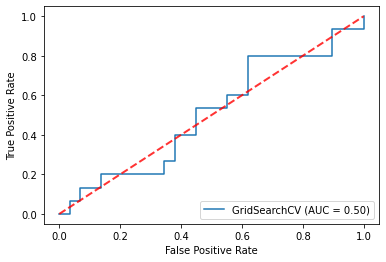

In [135]:
fig, ax = plt.subplots()
plot_roc_curve(search, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=.8)
plt.show()

## Bottleneck Distance Analysis

We check how the TPS outcome relates to the bottleneck distances between diagrams. We start by extracting the diagrams.

In [7]:
point_cloud_dgms = {}

point_cloud_dgms["dim0"] = list()
point_cloud_dgms["dim1"] = list()
point_cloud_dgms["dim2"] = list()

diagram_path_point_cloud_dim0 = os.path.join("diagram", "point_cloud", "dgm0")
diagram_path_point_cloud_dim1 = os.path.join("diagram", "point_cloud", "dgm1")
diagram_path_point_cloud_dim2 = os.path.join("diagram", "point_cloud", "dgm2")

for idx in range(len(os.listdir(diagram_path_point_cloud_dim0))):

    patient = "patient" + str(idx).zfill(3)
    point_cloud_dgms["dim0"].append(np.load(os.path.join(diagram_path_point_cloud_dim0, patient + ".npy")))

for idx in range(len(os.listdir(diagram_path_point_cloud_dim1))):

    patient = "patient" + str(idx).zfill(3)
    point_cloud_dgms["dim1"].append(np.load(os.path.join(diagram_path_point_cloud_dim1, patient + ".npy")))

for idx in range(len(os.listdir(diagram_path_point_cloud_dim2))):

    patient = "patient" + str(idx).zfill(3)
    point_cloud_dgms["dim2"].append(np.load(os.path.join(diagram_path_point_cloud_dim2, patient + ".npy")))

We calculate the bottleneck distances between the 0-dimensional point cloud persistence diagrams.

In [22]:
bndist0 = np.zeros([len(point_cloud_dgms["dim0"]), len(point_cloud_dgms["dim0"])])

no_to_compute = bndist0.shape[0] * (bndist0.shape[0] - 1) / 2
no_computed = 0

for idx1 in range(bndist0.shape[0] - 1):
    for idx2 in range(idx1 + 1, bndist0.shape[0]):
        print("progress: " + str(round(100 * no_computed / no_to_compute, 2)).ljust(5, "0") + "%", end="\r")
        bndist0[idx1, idx2] = gudhi.bottleneck_distance(point_cloud_dgms["dim0"][idx1], 
                                                        point_cloud_dgms["dim0"][idx2])
        bndist0[idx2, idx1] = bndist0[idx1, idx2]
        no_computed += 1

print("progress: 100.0%", end="\r")

We visualize how the bottleneck distances between the 0-dimensional diagrams relate to the TPS outcome

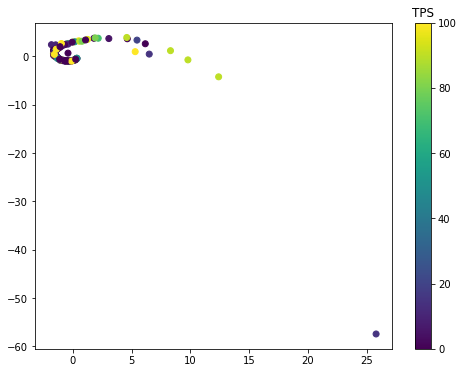

In [53]:
bnMDS0 = MDS(dissimilarity="precomputed", random_state=42).fit_transform(bndist0)

fig, ax = plt.subplots(figsize=(8, 6))
points = ax.scatter(bnMDS0[:,0], bnMDS0[:,1], c=meta["TPS"])
cbar = plt.colorbar(points)
cbar.ax.set_title("TPS")

plt.show()

We calculate the bottleneck distances between the 1-dimensional point cloud persistence diagrams.

In [54]:
bndist1 = np.zeros([len(point_cloud_dgms["dim1"]), len(point_cloud_dgms["dim1"])])

no_to_compute = bndist1.shape[0] * (bndist1.shape[0] - 1) / 2
no_computed = 0

for idx1 in range(bndist1.shape[0] - 1):
    for idx2 in range(idx1 + 1, bndist1.shape[0]):
        print("progress: " + str(round(100 * no_computed / no_to_compute, 2)).ljust(5, "0") + "%", end="\r")
        bndist1[idx1, idx2] = gudhi.bottleneck_distance(point_cloud_dgms["dim1"][idx1], 
                                                        point_cloud_dgms["dim1"][idx2])
        bndist1[idx2, idx1] = bndist1[idx1, idx2]
        no_computed += 1

print("progress: 100.0%", end="\r")

We visualize how the bottleneck distances between the 1-dimensional diagrams relate to the TPS outcome

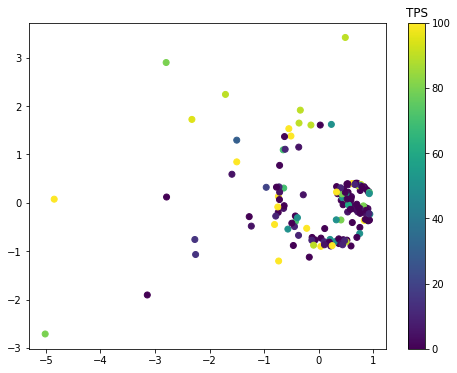

In [55]:
bnMDS1 = MDS(dissimilarity="precomputed", random_state=42).fit_transform(bndist1)

fig, ax = plt.subplots(figsize=(8, 6))
points = ax.scatter(bnMDS1[:,0], bnMDS1[:,1], c=meta["TPS"])
cbar = plt.colorbar(points)
cbar.ax.set_title("TPS")

plt.show()

We calculate the bottleneck distances between the 2-dimensional point cloud persistence diagrams.

In [58]:
bndist2 = np.zeros([len(point_cloud_dgms["dim2"]), len(point_cloud_dgms["dim2"])])

no_to_compute = bndist2.shape[0] * (bndist2.shape[0] - 1) / 2
no_computed = 0

for idx1 in range(bndist2.shape[0] - 1):
    for idx2 in range(idx1 + 1, bndist2.shape[0]):
        print("progress: " + str(round(100 * no_computed / no_to_compute, 2)).ljust(5, "0") + "%", end="\r")
        bndist2[idx1, idx2] = gudhi.bottleneck_distance(point_cloud_dgms["dim2"][idx1], 
                                                        point_cloud_dgms["dim2"][idx2])
        bndist2[idx2, idx1] = bndist2[idx1, idx2]
        no_computed += 1

print("progress: 100.0%", end="\r")

We visualize how the bottleneck distances between the 2-dimensional diagrams relate to the TPS outcome

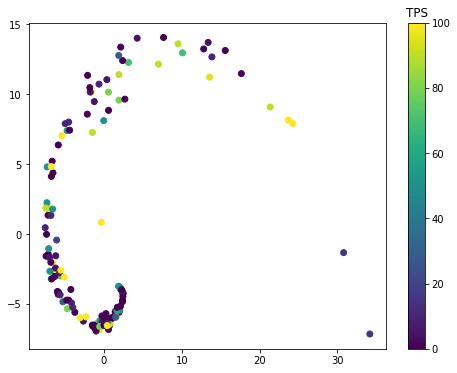

In [59]:
bnMDS2 = MDS(dissimilarity="precomputed", random_state=42).fit_transform(bndist2)

fig, ax = plt.subplots(figsize=(8, 6))
points = ax.scatter(bnMDS2[:,0], bnMDS2[:,1], c=meta["TPS"])
cbar = plt.colorbar(points)
cbar.ax.set_title("TPS")

plt.show()